In [67]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(themis)
library(ggplot2)
library(yardstick)

In [68]:
players <- read_csv("players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Can we predict whether a player subscribes to the server’s email newsletter using their age, self-reported gender, and total hours played on the Minecraft research server?

In [69]:
players_clean <- players|>
        mutate(
            subscribe = as.factor(subscribe),
           experience = case_when(
                experience == "Beginner" ~ 1,
               experience == "Amateur" ~ 2,
               experience == "Regular" ~ 3,
               experience == "Veteran" ~ 4,
               experience == "Pro" ~ 5),
            gender = case_when(
                gender == "Male" ~ 1,
                gender == "Female" ~ 2,
                gender == "Non-binary" ~ 3,
                gender == "Two-Spirited" ~ 4,
                gender == "Agender" ~ 5,
                gender == "Prefer not to say" ~ 6) 
            )|>
        drop_na() 

In [70]:
players_clean_viz <- players|>
           mutate(
            subscribe = as.factor(subscribe),
            experience = factor(
                experience,
                levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro")
                ))|>
        drop_na() 

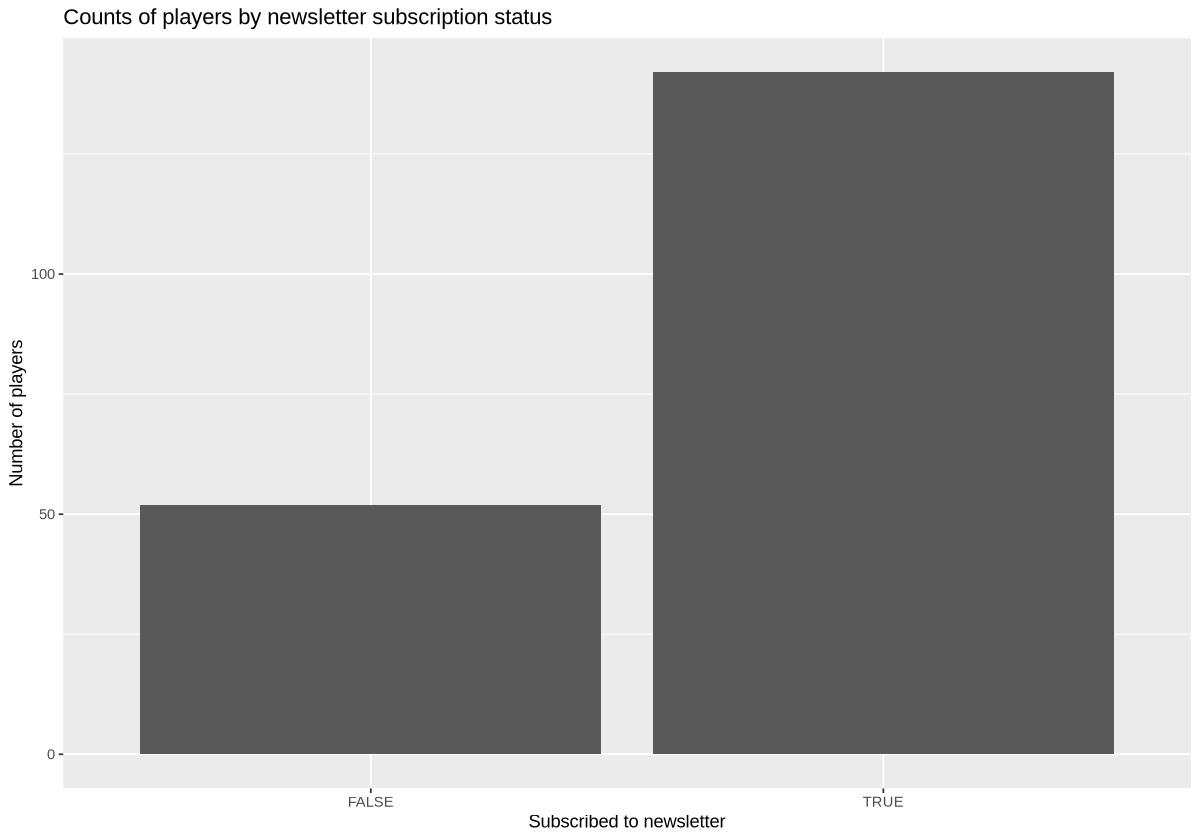

In [71]:
players_clean |>
    ggplot(aes(x = subscribe)) +
    geom_bar() +
    labs(
        title = "Counts of players by newsletter subscription status", 
        x = "Subscribed to newsletter",
        y = "Number of players"
        )

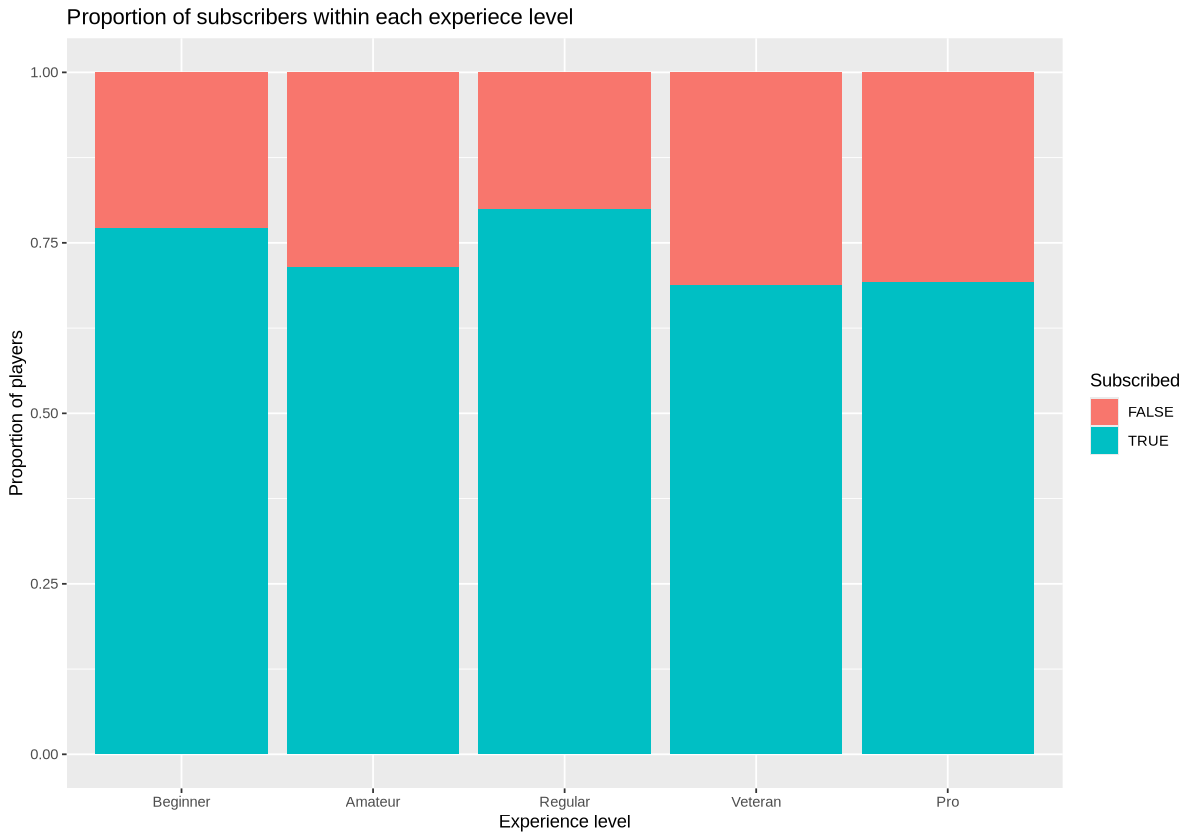

In [72]:
players_clean_viz |>
    ggplot(aes(x = experience, fill = subscribe))+
    geom_bar(position = "fill") + 
    labs(
        title = "Proportion of subscribers within each experiece level",
        x = "Experience level",
        y = "Proportion of players",
        fill = "Subscribed"
        )

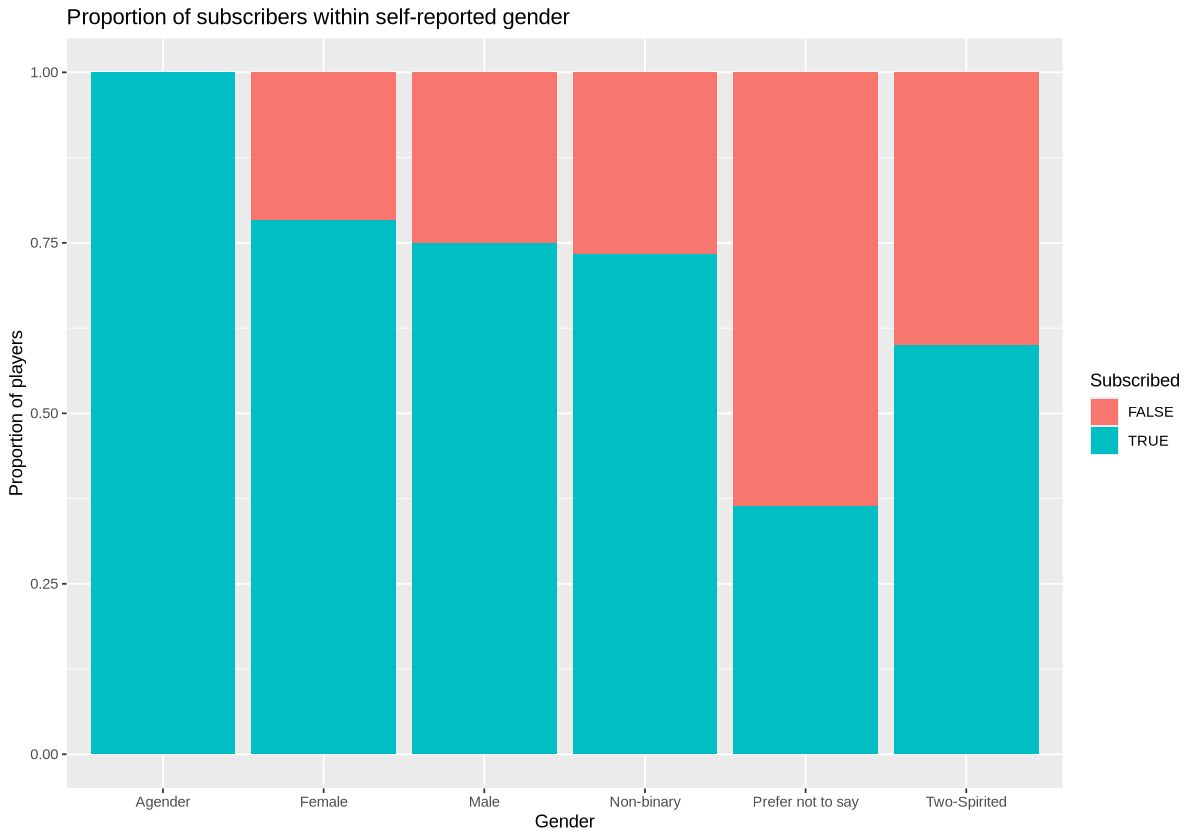

In [73]:
players_clean_viz |>
    ggplot(aes(x = gender, fill = subscribe))+
    geom_bar(position = "fill") + 
    labs(
        title = "Proportion of subscribers within self-reported gender",
        x = "Gender",
        y = "Proportion of players",
        fill = "Subscribed"
        )

In [74]:
set.seed(3456)
player_split <- initial_split(players_clean, prop = 0.75, strata = subscribe)  
player_train <- training(player_split)   
player_test <- testing(player_split)

In [75]:
options(warn = -1)
player_recipe <- recipe(subscribe ~ Age + played_hours + gender , data = player_train) |>
step_dummy(all_nominal_predictors())|>
step_scale(all_predictors()) |>
step_center(all_predictors())|>
step_upsample(subscribe, over_ratio = 1) #to fix the class imbalance
player_recipe 

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("classification")

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 5)) 



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 3



── Operations 

• Dummy variables from: all_nominal_predictors()

• Scaling for: all_predictors()

• Centering for: all_predictors()

• Up-sampling based on: subscribe



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4625123,5,0.04245954,Preprocessor1_Model01
1,roc_auc,binary,0.4307900,5,0.06269047,Preprocessor1_Model01
6,accuracy,binary,0.4751232,5,0.02153729,Preprocessor1_Model02
6,roc_auc,binary,0.5095315,5,0.05021452,Preprocessor1_Model02
11,accuracy,binary,0.5308374,5,0.04964325,Preprocessor1_Model03
11,roc_auc,binary,0.5229399,5,0.05947323,Preprocessor1_Model03
16,accuracy,binary,0.5384401,5,0.01745610,Preprocessor1_Model04
16,roc_auc,binary,0.5146297,5,0.04501852,Preprocessor1_Model04
21,accuracy,binary,0.6002791,5,0.03604811,Preprocessor1_Model05


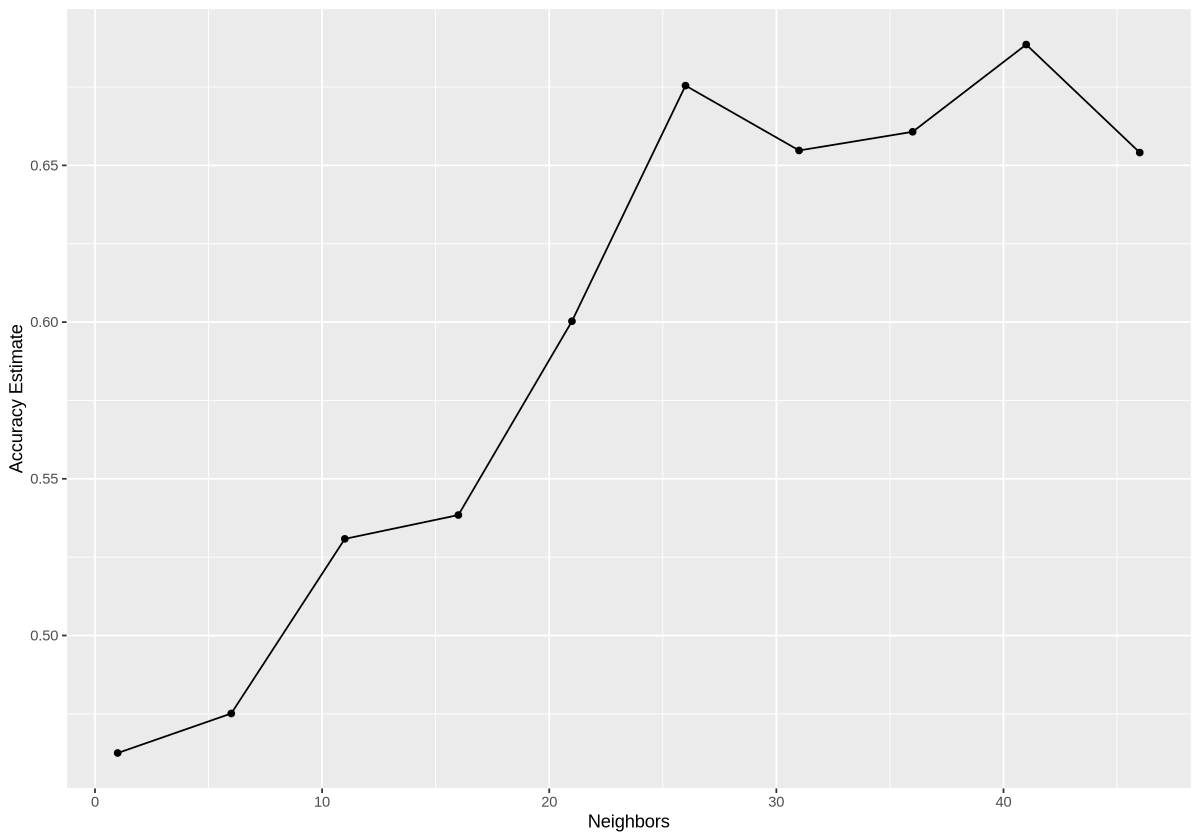

In [76]:
options(warn = 0)
options(repr.plot.height = 7, repr.plot.width = 10)
knn_results <- workflow() |> 
       add_recipe(player_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = player_vfold, grid = k_vals) |>
       collect_metrics()
knn_results

accuracy <- knn_results|>
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracy, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") 
accuracy_vs_k

In [77]:
best_k <- accuracy |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 41

In [78]:
best_player_recipe <- recipe(subscribe ~ Age + played_hours + gender, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) #remake model with the best k

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(best_player_recipe) |>
  add_model(knn_spec) |>
  fit(data = player_train)
knn_fit

player_test_predictions <- predict(knn_fit, player_test) |>
  bind_cols(player_test)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")
player_test_predictions

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(41,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2689655
Best kernel: rectangular
Best k: 41

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age
<fct>,<dbl>,<fct>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
TRUE,2,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,2,21
TRUE,3,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,1,21
TRUE,2,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,2,17
TRUE,2,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,1,47
TRUE,5,TRUE,4caa42e1b20511552434978171dcf7283fb6eb857eb871327e39bfc328002309,0.0,Daniela,1,17
TRUE,2,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,2,17
TRUE,3,TRUE,5baba1651a0b92788bc0d6dcdf00be64af1cf9f0015bbeed204ddabd1d872e83,0.6,Kendall,2,28
TRUE,2,TRUE,4b01bce3f141289709e8278b02ba5d2aaa7105d7ccb9c7deb37670a80e332774,1.8,Luca,1,23
TRUE,1,TRUE,f459ce1862ec9a43b6c714810390dfd632ed104eb11378b3a2a134b1b107bc75,0.6,Jabari,1,26


In [79]:
confusion <- player_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

In [80]:
precision <- 36/36
precision
recall <- 36/(36+13)
recall

[1] 1

[1] 0.7346939

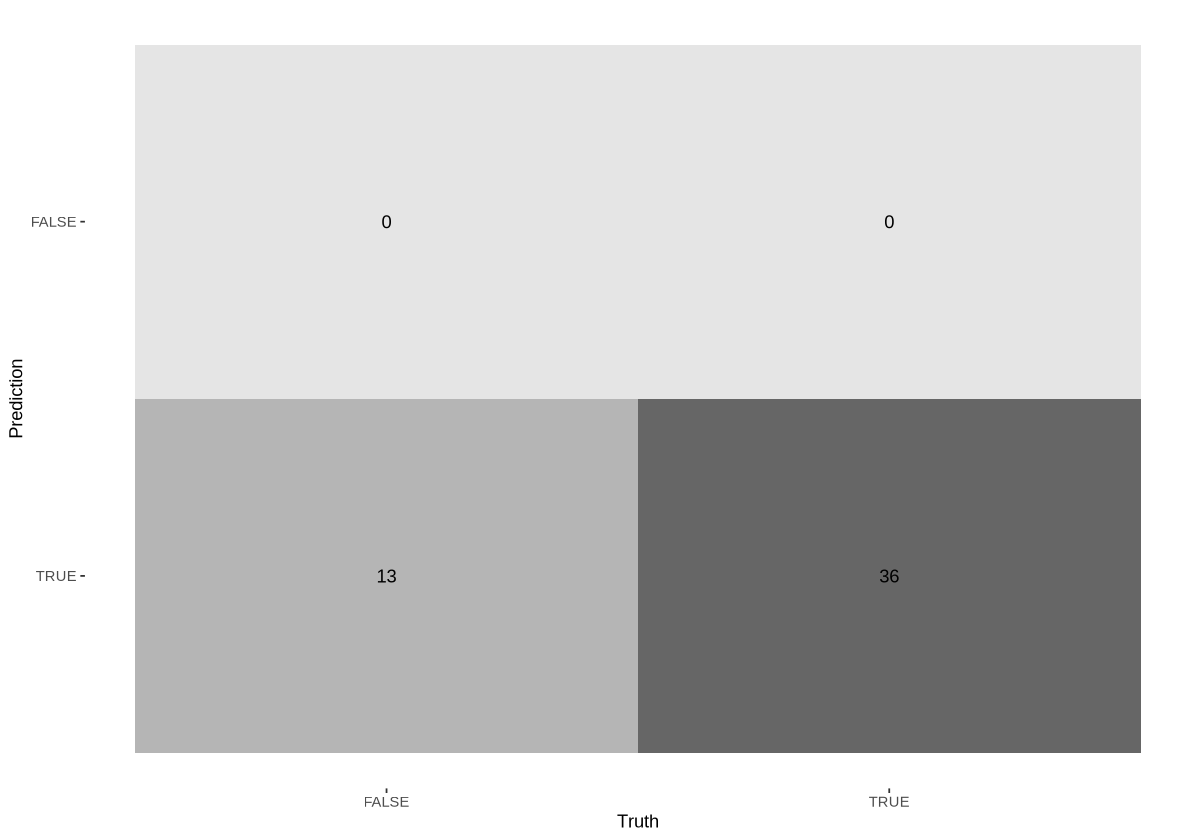

In [81]:
autoplot(confusion, type = "heatmap")

It's kinda weird how there's no true negatives